# Reinforcement Learning for Navigation

In [125]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import MultiAgentVecEnv

from mlagents_envs.exception import UnityTimeOutException, UnityWorkerInUseException
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

import torch as th

import os, yaml
import random
import time
import datetime
import numpy as np
import torch as th
from torch import nn

from mlagents_envs.environment import UnityEnvironment
from gym_unity.envs import UnityToMultiGymWrapper 
import wandb
from rlnav.logging import WANDBMonitor, test_model
from rlnav.schedules import linear_schedule
from pathlib import Path


In [126]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [242]:
observations = np.load('observation505_fixed.npy')
observations = observations.squeeze()

vector_size = 19 
whisker_size = 26 + 6 
depth_size = 55 - 6
occupancy_size = 405

vector_end = vector_size
whisker_end = vector_end + whisker_size
depth_end = whisker_end + depth_size
occupancy_end = depth_end + occupancy_size

In [243]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

In [244]:
index = 30

vec_obs = observations[:, 0:vector_end]
whisker_obs = observations[:, vector_end:whisker_end]
depth_obs = observations[:, whisker_end:depth_end]
occupancy_obs = observations[:, depth_end:occupancy_end]

# print(vec_obs, whisker_obs, depth_obs, occupancy_obs)
# print(vec_obs.shape, whisker_obs.shape, depth_obs.shape, occupancy_obs.shape)
print(vec_obs.shape[1]+ whisker_obs.shape[1]+ depth_obs.shape[1] + occupancy_obs.shape[1])

505


### Depthmask

In [245]:
depth_obs.shape

(1000000, 49)

In [246]:
print(depth_obs[10000])

[0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997
 0.        0.        0.        0.        0.        0.9295996 0.4421997]


In [247]:
depth_obs.shape
depth_obs_2d = depth_obs.reshape(-1, 7, 7)  ### Occupancy Grid
depth_obs_2d.shape

(1000000, 7, 7)

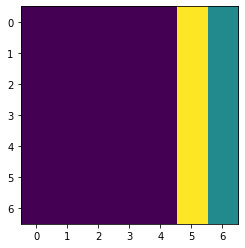

In [257]:
imshow(depth_obs_2d[0])

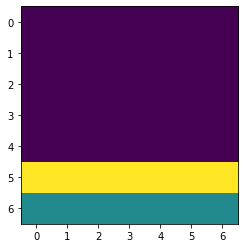

In [249]:
imshow(depth_obs_2d[10000].T)

### Occupancy Grid

In [250]:
occupancy_obs.shape

(1000000, 405)

In [251]:
# z, y, x ordering
occupancy_obs_3d = occupancy_obs.reshape(1000000, 1, 9, 9, 5)
occupancy_obs_3d_plt = np.swapaxes(occupancy_obs_3d, -1, -2)
occupancy_obs_3d_plt = np.swapaxes(occupancy_obs_3d_plt, -2, -3)
occupancy_obs_3d_plt = occupancy_obs_3d_plt.squeeze()

In [252]:
np.sum(occupancy_obs_3d_plt[157])

252.0

In [253]:
# occupancy_obs_3d = np.random.uniform(0,1,405*32).reshape(-1, 1, 9, 5, 9)
# occupancy_obs_3d.shape

In [254]:
conv3d_layer = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv3d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.Conv3d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            # nn.Conv3d(128, 128, kernel_size=2, padding=0, stride=2), nn.ReLU(),
            nn.MaxPool3d(2),
        ).to("cpu")
th.squeeze(conv3d_layer(th.tensor(occupancy_obs_3d[0:32]))).shape

torch.Size([32, 128])

In [255]:
# idx = random.randint(0,10000)
print(idx)

6554


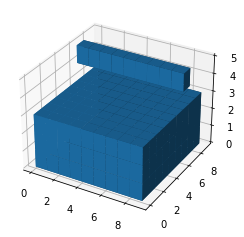

In [256]:
occupancy_obs_3d = occupancy_obs.reshape(1000000, 1, 9, 5, 9)
occupancy_obs_3d = np.swapaxes(occupancy_obs_3d, -1, -2)
occupancy_obs_3d_plt = occupancy_obs_3d.squeeze()
ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(occupancy_obs_3d_plt[idx-1])

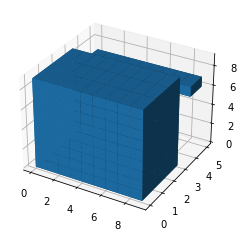

In [140]:
occupancy_obs_3d = occupancy_obs.reshape(1000000, 1, 9, 5, 9)
occupancy_obs_3d_plt = occupancy_obs_3d.squeeze()
ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(occupancy_obs_3d_plt[idx-1])

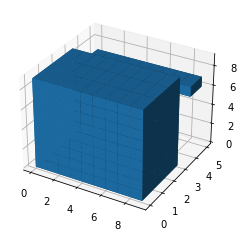

In [116]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(occupancy_obs_3d_plt[idx+0])

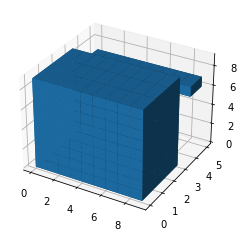

In [117]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(occupancy_obs_3d_plt[idx+1])

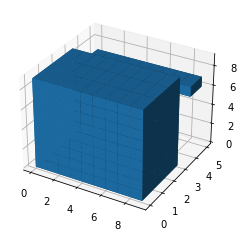

In [118]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(occupancy_obs_3d_plt[idx])

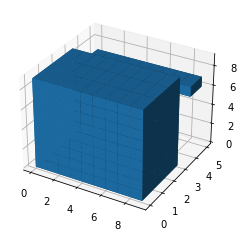

In [119]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(occupancy_obs_3d_plt[idx])

In [177]:
class CustomNetwork(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dim: int = 1024,
        squash_output: bool = False, ):
        super(CustomNetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.squash_output = squash_output
        self.hidden_dim = hidden_dim

        self.action_dim = 3 
        self.vector_end = 25 # index of where the vector observation ends in observation
 
        self.raycast_size = 7 
        self.depthmask_end = self.vector_end + self.raycast_size * self.raycast_size
 
        self.occupancy_shape = (9, 5, 9)
 
        self.isCritic = output_dim > 0 
        
        self.model = self.create_model()

    def create_model(self):

        conv2d_size = 32
        self.depthmask_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=conv2d_size, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(conv2d_size, conv2d_size, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(7),
        ) 

        conv3d_size = 32
        self.occupancy_layers= nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=conv3d_size, kernel_size=3, stride=1, padding=2), nn.ReLU(),
            nn.Conv3d(conv3d_size, conv3d_size, kernel_size=3, padding=2), nn.ReLU(),
            nn.MaxPool3d(kernel_size=(15,5,15)),
        )

        # If you are the critic your vector obs also involes the actions from the actor
        vector_input = self.vector_end + self.action_dim if self.isCritic else self.vector_end
        self.vector_layers = nn.Sequential(
            nn.Linear(vector_input, self.hidden_dim), nn.ReLU(),
        )

        # Whether the output 3 actions, or the hidden size (the mu and sigma used for SAC actor is created later, outside the scope of this class)
        output_size = self.output_dim if self.isCritic else self.hidden_dim
        model_list =[
            nn.Linear(self.hidden_dim + conv3d_size + conv2d_size, self.hidden_dim), nn.ReLU(),
            nn.Linear(self.hidden_dim, output_size), nn.ReLU(),
        ]

        if self.squash_output:
            model_list.append(nn.Tanh())

        self.combo_model = nn.Sequential(*model_list)

    def forward(self, input_tensor: th.Tensor) -> th.Tensor:
        # Divide the incoming 1d observation into three parts, reshape it as necesarry.
        # if it is the critic, append the actions (given as input) to the end of the vector obs
        vector_obs = th.cat((input_tensor[:, :self.vector_end], input_tensor[:, -self.action_dim:]),dim=1) if self.isCritic else input_tensor[:, :self.vector_end]
        depth_obs = input_tensor[:, self.vector_end:self.depthmask_end]
        occupancy_obs = input_tensor[:, self.depthmask_end: -self.action_dim]  if self.isCritic else input_tensor[:, self.depthmask_end:]
        
        # Reshape to the correct size and pass it through the network.
        depth_output = th.squeeze(self.depthmask_layers(depth_obs.reshape(-1, 1, self.raycast_size, self.raycast_size)))
        occupancy_output = th.squeeze(self.occupancy_layers(occupancy_obs.reshape(-1, 1, *self.occupancy_shape)))
        vector_output = self.vector_layers(vector_obs)
        
        # Get the combination and pass it through the last linear layers.
        combined_input = th.cat((vector_output, occupancy_output, depth_output), dim=1)
        output = self.combo_model(combined_input)
        return output

In [179]:
net = CustomNetwork(505, 3)
net.create_model()

#### Appendix

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, dropout=0, dim_feedforward=512)
src = th.rand(32, 1, 512)
# src = src.view(32,1,512)
out = encoder_layer(src)
out.shape

In [ ]:
class CustomNetwork(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dim: int = 1024,
        n_layers: int = 2,
        squash_output: bool = False,
    ):
        super(CustomNetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.squash_output = squash_output
        self.hidden_dim = hidden_dim
        self.isCritic = output_dim > 0 
        
        self.model = self.create_model()

    def create_model(self):
        self.depthmask = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(7),
        ) 

        self.occupancy= nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=2), nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=3, padding=2), nn.ReLU(),
            nn.MaxPool3d(5),
        )

        vector_input = 54 if self.isCritic else 51
        self.vector = nn.Sequential(
            nn.Linear(vector_input, self.hidden_dim), nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim), nn.ReLU(),
        )

        total_size = 467 if self.isCritic else 464
        model_list =[
            nn.Linear(total_size, self.hidden_dim), nn.ReLU(),
        ]
        if self.output_dim > 0:
            model_list.append(nn.Linear(self.hidden_dim, self.output_dim))

        if self.squash_output:
            model_list.append(nn.Tanh())

        self.combo_model = nn.Sequential(*model_list)

    def forward(self, input_tensor: th.Tensor) -> th.Tensor:
        vector_obs = th.cat((input_tensor[:, 54], input_tensor[:, -3:])) if self.isCritic else input_tensor[:, 51]
        depth_obs = input_tensor[:, 52:101]
        occupancy = input_tensor[:, 101:-3]  if self.isCritic else input_tensor[:, 101:]
        
        depth_output = th.squeeze(self.depthmask(depth_obs.reshape(-1,1,7,7)))
        occupancy_output = th.squeeze(self.occupancy(occupancy.reshape(-1,1, 11, 3, 11)))
        vector_output = self.vector(vector_obs)
        
        combined_input = th.cat((vector_output, occupancy_output, depth_output), dim=1)
        output = self.combo_model(combined_input)
        return output
    
CustomNetwork(464,3)

In [ ]:
class CustomNetwork(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dim: int = 1024,
        n_layers: int = 2,
        squash_output: bool = False,
    ):
        super(CustomNetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.squash_output = squash_output
        self.hidden_dim = hidden_dim
        self.isCritic = output_dim > 0 
        
        self.model = self.create_model()

    def create_model(self):
        self.depthmask = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(7),
        ) 

        self.occupancy= nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=2), nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=3, padding=2), nn.ReLU(),
            nn.MaxPool3d(5),
        )

        vector_input = 54 if self.isCritic else 51
        self.vector = nn.Sequential(
            nn.Linear(vector_input, self.hidden_dim), nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim), nn.ReLU(),
        )

        total_size = 467 if self.isCritic else 464
        model_list =[
            nn.Linear(total_size, self.hidden_dim), nn.ReLU(),
        ]
        if self.output_dim > 0:
            model_list.append(nn.Linear(self.hidden_dim, self.output_dim))

        if self.squash_output:
            model_list.append(nn.Tanh())

        self.combo_model = nn.Sequential(*model_list)

    def forward(self, input_tensor: th.Tensor) -> th.Tensor:
        vector_obs = th.cat((input_tensor[:, 54], input_tensor[:, -3:])) if self.isCritic else input_tensor[:, 51]
        depth_obs = input_tensor[:, 52:101]
        occupancy = input_tensor[:, 101:-3]  if self.isCritic else input_tensor[:, 101:]
        
        depth_output = th.squeeze(self.depthmask(depth_obs.reshape(-1,1,7,7)))
        occupancy_output = th.squeeze(self.occupancy(occupancy.reshape(-1,1, 11, 3, 11)))
        vector_output = self.vector(vector_obs)
        
        combined_input = th.cat((vector_output, occupancy_output, depth_output), dim=1)
        output = self.combo_model(combined_input)
        return output
    
CustomNetwork(464,3)

In [ ]:
occupancy= nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=2), nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=3, padding=2), nn.ReLU(),
            nn.MaxPool3d(kernel_size=(15,5,15)),
#             nn.Flatten()
        )
print(occupancy)

In [ ]:
imp = th.tensor(observations.flatten()[0:363*32].reshape(-1, 1, 11,3,11))

In [ ]:
occupancy(th.tensor(imp[0:16])).shape

In [ ]:
PROTOTYPE_NAME = "JumpV3"
EXPERIMENT_NAME = f"Baseline"
TREATMENT_NAME = "THIS"
ENV_NAME = "BoxSize2_463"
base_bath = Path(fr"C:\Users\batua\Desktop\RLNav\NavigationEnvironments\{PROTOTYPE_NAME}")
ENV_PATH = base_bath / fr"{ENV_NAME}\Env.exe"  

In [ ]:
wandb_config = {}
def make_env(rank, seed=0):
  def _init():
    channel = EngineConfigurationChannel()
    unity_env = UnityEnvironment(str(ENV_PATH), base_port=5000 + rank, side_channels=[channel])
    env = UnityToMultiGymWrapper(unity_env)
    env = WANDBMonitor(env, wandb_config, prototype=f"{PROTOTYPE_NAME}", experiment=EXPERIMENT_NAME, treatment=TREATMENT_NAME)
    channel.set_configuration_parameters(time_scale = 5)
    return env
  return _init

env = MultiAgentVecEnv(make_env(512))

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from rlnav.custom_networks import SACCustomPolicy

In [ ]:
# observations = np.load('data/observations.npy')
# actions = np.load('data/actions.npy')
# dones = np.load('data/dones.npy')
# rewards = np.load('data/rewards.npy')

In [ ]:
class RLNetwork(nn.Module):
    def __init__(self):
        super(RLNetwork, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
#           nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(input_size),
        ).to(device)
        
        conv3d_layer = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=2), nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=3, padding=2), nn.ReLU(),
            nn.MaxPool3d(5),
        ).to(device)
        
        self.vector_layer = nn.Sequential(
            nn.Linear(99, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
        ).to(device)
        
        self.combined_layer = nn.Sequential(
            nn.Linear(256 + 128, 3)).to(device)
        
    def forward(self, features: th.Tensor):
        features.to(device)
        vec_obs = features[:, :99]
        depth_obs = features[:, 99:].reshape(-1, 1, 7, 7)

        vec = self.vector_layer(vec_obs)
        depth = th.squeeze(self.conv_layer(depth_obs))

        merged = th.cat((vec, depth), 1)
        output = self.combined_layer(merged)
        return output

In [ ]:
model = RLNetwork()
print(model)

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

In [ ]:
input_size = 7

th.squeeze(conv_layer(th.tensor(depth_obs_2d[:16])))        

In [ ]:
in_channels, out_channels, kernel_size, stride=1,
conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=1), nn.ReLU(),
            nn.Flatten(),
        )
conv_layer(th.tensor(depth_obs_2d[:16])).shape

In [ ]:
from typing import Callable, Dict, List, Optional, Tuple, Type, Union

import gym
import torch as th
from torch import nn

from stable_baselines3 import SAC
from stable_baselines3.common.policies import ActorCriticPolicy


class CustomNetwork(nn.Module):
    """
    Custom network for policy and value function.
    It receives as input the features extracted by the feature extractor.

    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 64,
        last_layer_dim_vf: int = 64,
    ):
        super(CustomNetwork, self).__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # Policy network
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_pi), nn.ReLU()
        )
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_vf), nn.ReLU()
        )

    def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        return self.policy_net(features), self.value_net(features)


class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        lr_schedule: Callable[[float], float],
        net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        *args,
        **kwargs,
    ):

        super(CustomActorCriticPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = False

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)


model = PPO(CustomActorCriticPolicy, "CartPole-v1", verbose=1)
model.learn(5000)